# VAE
Based off of Alexander Van de Kleut's work. See [this post](https://avandekleut.github.io/vae/) for some theory and explination.

## Checklist
- ~~check your data: make sure the experimental data is not normalized (know expected ranges, it is for sure centered at zero).~~ **Range is `-0.3192:1.1109`
- ~~make artificial data more similar to experimental (match the same range)~~
- loss function values: if we see large numbers not going to zero, double check where the value is coming from (autoencode single example and compare to OG)
    - if you cannot get low loss no matter what, check if you need to add more layers, latent dimensions...
    - should expect good reconstruction capabilities
    - ~~if actually -1 to 1 (check w loop) constrain output with tanh:~~ Not actually -1:1
    - separate loss function (call within forward)
- ~~in artificial data, subtract the mean (of individual image) and subtract from the entire guy~~

In [8]:
import torch; torch.manual_seed(0)
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt;
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
parent_folder1 = '/Users/jamiestickelmaier/Documents/Capstone/' 
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'
models_folder = parent_folder + 'wonglab-capstone/DotsTorch/Trained_models/'

class ArtKymoDataset(Dataset):
    def __init__(self):
        # Data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        # Mean centering to match artificial data
        for i, kymo in enumerate(kymos):
            kymo = np.divide(kymo,np.mean(kymo))
            kymos[i] = kymo
        kymos = torch.from_numpy(kymos)
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

class ExpKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(exp_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read()))
        kymos = kymos.astype('float32')
        self.x = torch.from_numpy(kymos)
        self.n_samples = kymos.shape[2]

    def __getitem__(self, index):
        return self.x[:,:,index]

    def __len__(self):
        return self.n_samples

## Convolutional VAE 3.0

In [12]:

class Encoder(nn.Module): #we must define our encoder as a subclass of the provided PyTorch neural network
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=60, hidden_dim=5000, latent_dim=100)
decoder = Decoder(latent_dim=100, hidden_dim =5000, output_dim = 60)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

from torch.optim import Adam

BCE_loss = nn.MSELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=1e-5)

#### VAE Training Loop

In [14]:
import time 

dataset = ArtKymoDataset()

print("---VAE Training---")
model.train()

for epoch in range(10):

    startTime = time.perf_counter()
    overall_loss = 0
    for batch_idx, (x) in enumerate(dataset):
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    timediff = (time.perf_counter()-startTime)
    print("\tEpoch {} complete \tAverage Loss: {} \tTraining time: {} ".format(epoch+1, overall_loss / len(dataset), timediff))
    
print("Finish!!")

---VAE Training---
	Epoch 1 complete 	Average Loss: 0.09453762217114368 	Training time: 139.08439510000005 
	Epoch 2 complete 	Average Loss: 0.0805525846282641 	Training time: 149.8163561 
	Epoch 3 complete 	Average Loss: 0.07563466917102536 	Training time: 161.55497130000003 
	Epoch 4 complete 	Average Loss: 0.07308925033236544 	Training time: 164.94409889999997 
	Epoch 5 complete 	Average Loss: 0.07137337489674489 	Training time: 7735.655692599999 
	Epoch 6 complete 	Average Loss: 0.07007937960947554 	Training time: 145.37361299999975 
	Epoch 7 complete 	Average Loss: 0.06901403410360217 	Training time: 152.49807259999943 
	Epoch 8 complete 	Average Loss: 0.0680491186864674 	Training time: 153.08308140000008 
	Epoch 9 complete 	Average Loss: 0.06718823769440253 	Training time: 249.51423090000026 
	Epoch 10 complete 	Average Loss: 0.0663408360692362 	Training time: 158.55505409999932 
Finish!!


In [15]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(autoencoder, data, dims=[0,1], exp_data=None):
    assert len(dims) == 2
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        #hacky way to label data
        if i < 99:
            plt.scatter(z[dims[0]], z[dims[1]], c='k', label = ('sin' if i == 1 else None))
        elif i < 199:
            plt.scatter(z[dims[0]], z[dims[1]], c='b', label = ('pol' if i == 101 else None), alpha = 0.8)
        else:
            plt.scatter(z[dims[0]], z[dims[1]], c='g', label = ('rand' if i == 201 else None), alpha = 0.5)

    if exp_data != None:
        for i, z in enumerate(exp_data):
            z.reshape(1,20,60)
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[dims[0]], z[dims[1]], c='r', label = ('Experimental' if i == 1 else None), alpha = 0.3)



    plt.xlabel('Latent Dim {}'.format(dims[0]))
    plt.ylabel('Latent Dim {}'.format(dims[1]))
    plt.legend(loc='upper right')
    plt.title('Kymograph position in Latent Space')
    plt.legend

#pick random kymographs to reconstruct and show
def plot_sample_im(autoencoder, data):
    plt.figure(figsize=(12,5))
    for i in range(3):
        idz = np.random.randint(i*100,i*100+100)
        print(idz)
        y = data[idz]
        z = autoencoder(data[idz].to(device))
        z = z.to('cpu').detach().numpy()
        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Actual Kymographs")
        plt.imshow(y[0,:,:], cmap='gray')
        plt.subplot(2,3,i+4)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        if i == 1:
            plt.title("Reconstructed Kymographs")
        plt.imshow(z[0,0,:,:], cmap='gray')
    plt.tight_layout()
    plt.show()

In [17]:
exp_dataset = ExpKymoDataset()
plot_latent(model, dataset, dims=[0,1], exp_data=exp_dataset)

# Current model needs more normalization, still large gaps in latent space...
# Implement PCA to compress latent_dims for visualization?
# Also should implement batching if possible, right now we iterate through entire
# dataset in the same order, probably leading to wonky reconstructions below as model overfits

AttributeError: 'Model' object has no attribute 'encoder'

In [42]:
def show_im(index):
    plt.subplot(1,2,1)
    plt.imshow(dataset[index].reshape(20,60), cmap='plasma')
    plt.subplot(1,2,2)
    plt.imshow(model(dataset[index])[0].detach().reshape(20,60).numpy(), cmap='plasma')

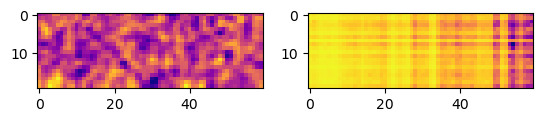

In [46]:
show_im(202)

We can see that the VAE is not doing a very good job at producing meaningful recondstructions however...
This is potentially because it is compressing into at pretty low dimensional latent space, giving it control only over total and relative brightness and some other unclear parameters, hence why all the reconstructed kymos look like scaled copies of one another despite separation in the latent space.

In [16]:
# Sample reconstructed kymographs
plot_sample_im(model, dataset)

52


AttributeError: 'tuple' object has no attribute 'to'

<Figure size 1200x500 with 0 Axes>

## Save and load models

## Save and load models

Check actual output from decoder and look at how it compares to the input. Error should not be 

In [115]:
# Set save_model = True and run cell to save model state
save_model = False
model_name = 'VAE_2.25.23.pt'

if save_model:
    torch.save(VAE.state_dict(), models_folder+model_name)

In [ ]:
# Set load_model = True and run cell to save model state
load_model = False
model_name = 'VAE_3.0.pt'

model = Autoencoder(latent_dims=2).to(device)
model.load_state_dict(torch.load(models_folder+model_name))
model.eval()